In [1]:
# If running Python 2.x, makes print and division act like Python 3
from __future__ import print_function, division

# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Enable inline plotting at lower left
%matplotlib inline

from IPython.display import display, Latex, clear_output

In [2]:
import pynrc
from pynrc import nrc_utils          # Variety of useful functions and classes
from pynrc.obs_nircam import obs_hci, nrc_hci # High-contrast imaging observation class

# Disable informational messages and only include warnings and higher
pynrc.setup_logging(level='WARN')

pyNRC log messages of level WARN and above will be shown.
pyNRC log outputs will be directed to the screen.


# Circular Masks

In [5]:
mask_arr = ['MASK210R', 'MASK335R', 'MASK430R']
filt_arr = ['F210M',    'F335M',    'F430M']

xy_offset = [(-15,15), (0,20), (15,15), (-20,0), (0,0), (20,0), (-15,-15), (0,-20), (15,-15)]
rt_offset = [nrc_utils.xy_to_rtheta(x, y) for x,y in xy_offset]

fov_pix = 128
osamp = 4

In [4]:
nrc_arr = []
for r, th in rt_offset:
    print('{:.1f} {:.1f}'.format(r, th))
    nrc = pynrc.NIRCam(pupil='CIRCLYOT', mask='MASK335R', filter='F335M', ngroup=10,
                       quick=True, force=True, save=False, fov_pix=fov_pix, oversample=osamp,
                       offset_r=r/1000., offset_theta=th, include_si_wfe=False)#,
#                        opd = ('OPD_RevW_ote_for_NIRCam_requirements.fits.gz', 5))
    
    nrc_arr.append(nrc)

21.2 45.0
20.0 0.0
21.2 -45.0
20.0 90.0
0.0 0.0
20.0 -90.0
21.2 135.0
20.0 180.0
21.2 -135.0


In [6]:
psf_arr = np.array([nrc.gen_psf(return_oversample=True)[1] for nrc in nrc_arr])

In [7]:
psf_sum = np.array([psf.sum() for psf in psf_arr])
psf_max = np.array([psf.max() for psf in psf_arr])
for psf in psf_arr:
    print(psf.sum())

0.0015269486480853764
0.0015252642435051918
0.0015254925515558594
0.0015268829979964652
0.0015204166335845873
0.0015257408187042468
0.0015283997635081267
0.0015280259922035016
0.0015282081657704875


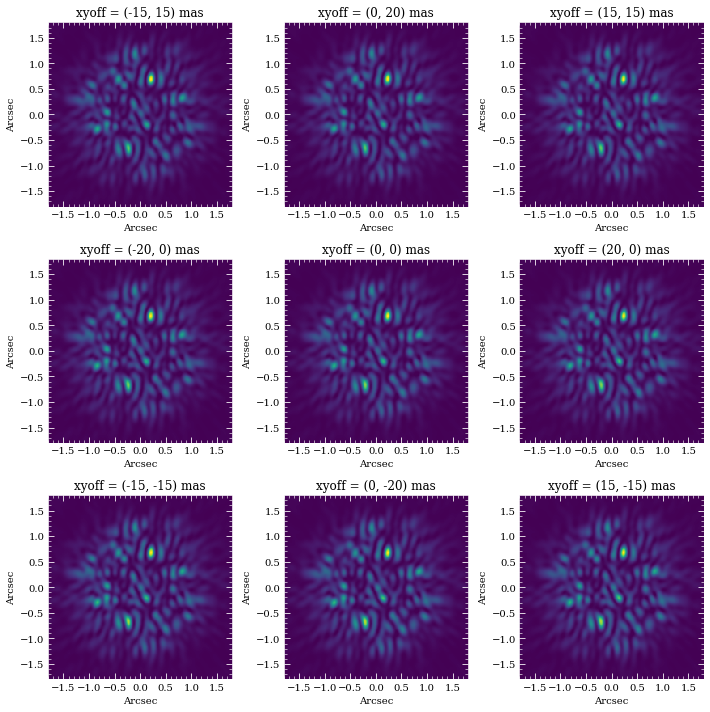

In [11]:
fig, axes = plt.subplots(3,3, figsize=(10,10))
axes = axes.flatten()

xylim = np.array([-1,1])*1.8
pixscale = nrc.pixelscale
pixscale_over = nrc.pixelscale / osamp
for i, ax in enumerate(axes):
    im = psf_arr[i]
    extent = np.array([-1,1,-1,1]) * pixscale_over * im.shape[0] / 2
    ax.imshow(im, extent=extent)
    
    ax.set_title('xyoff = {} mas'.format(xy_offset[i]))
    
    ax.set_xlim(xylim)
    ax.set_ylim(xylim)
    
    ax.set_xlabel('Arcsec')
    ax.set_ylabel('Arcsec')

    ax.xaxis.get_major_locator().set_params(nbins=9, steps=[1, 2, 5, 10])
    ax.yaxis.get_major_locator().set_params(nbins=9, steps=[1, 2, 5, 10])
    
    ax.tick_params(axis='both', color='white', which='both')
    for k in ax.spines.keys():
        ax.spines[k].set_color('white')

    
fig.tight_layout()

In [42]:
psf_mean = np.mean(psf_arr, axis=0)
psf_resid0 = psf_arr - psf_arr[4]

psf_resid = []
for i, psf in enumerate(psf_arr):
    diff0 = psf - psf_arr[4]

    xoff, yoff = xy_offset[i]
    xoff = xoff / (pixscale_over * 1000)
    yoff = yoff / (pixscale_over * 1000)
    
    psf = nrc_utils.fourier_imshift(psf, -xoff, -yoff, pad=True)
    diff = psf - psf_arr[4]
    
    psf_resid.append(diff)
    
    diff0_rebin = nrc_utils.frebin(diff0, dimensions=fov_pix)
    diff_rebin = nrc_utils.frebin(diff, dimensions=fov_pix)
    print('({:.2f} {:.2f}) {} {} {}'.format(xoff, yoff, np.max(np.abs(diff_rebin))/np.sum(psf), 
                                         np.max(np.abs(diff0_rebin))/np.sum(psf), np.sum(psf)))
    
psf_resid = np.array(psf_resid)

(-0.95 0.95) 0.0002570871082568284 0.0010333453446863016 0.0015267088031916491
(0.00 1.27) 0.00019859791110139258 0.000652569205219796 0.0015251153694501873
(0.95 0.95) 0.00017324851815185235 0.0009089915830143427 0.0015252632719831882
(-1.27 0.00) 0.0001445130336850774 0.0010844818428877893 0.0015266814907103645
(0.00 0.00) 1.1490307427071443e-18 0.0 0.0015204166335845873
(1.27 0.00) 0.00020959957904546998 0.0009992601267227001 0.0015255534631294322
(-0.95 -0.95) 0.00013248674762489606 0.0007962019165044307 0.0015281869181983678
(0.00 -1.27) 0.00025125072147970823 0.0006112934774955769 0.0015279104252998502
(0.95 -0.95) 0.00033493280021543273 0.0007628498196206474 0.0015280054673858271


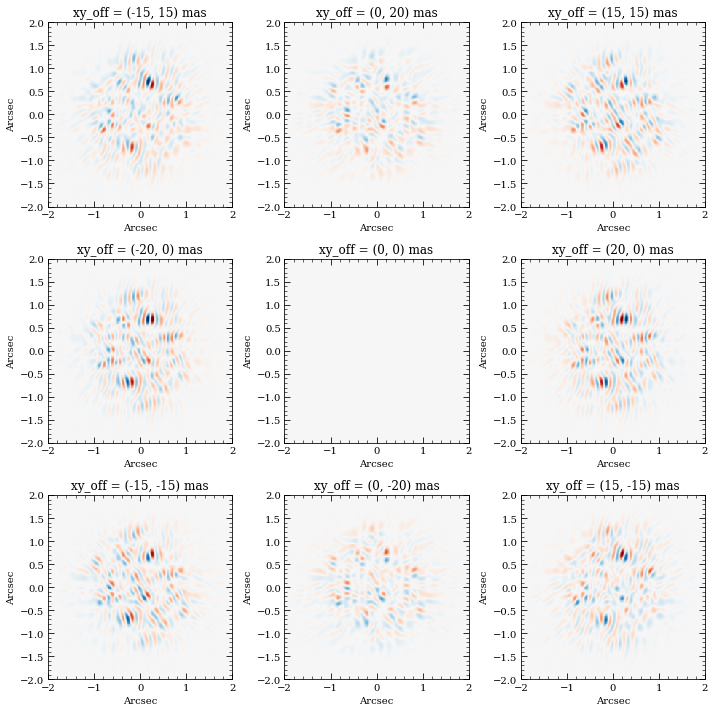

In [29]:
fig, axes = plt.subplots(3,3, figsize=(10,10))
axes = axes.flatten()


im = psf_resid0[0]
vmin, vmax = np.array([-1,1]) * np.max(np.abs(im)) * 0.9
xylim = np.array([-1,1])*2
for i, ax in enumerate(axes):
    im = psf_resid0[i]
    
    
    extent = np.array([-1,1,-1,1]) * pixscale_over * im.shape[0] / 2
    ax.imshow(im, vmin=vmin, vmax=vmax, extent=extent, cmap='RdBu')
    
    ax.set_title('xy_off = {} mas'.format(xy_offset[i]))
    
    ax.set_xlim(xylim)
    ax.set_ylim(xylim)
    
    ax.set_xlabel('Arcsec')
    ax.set_ylabel('Arcsec')

fig.tight_layout()

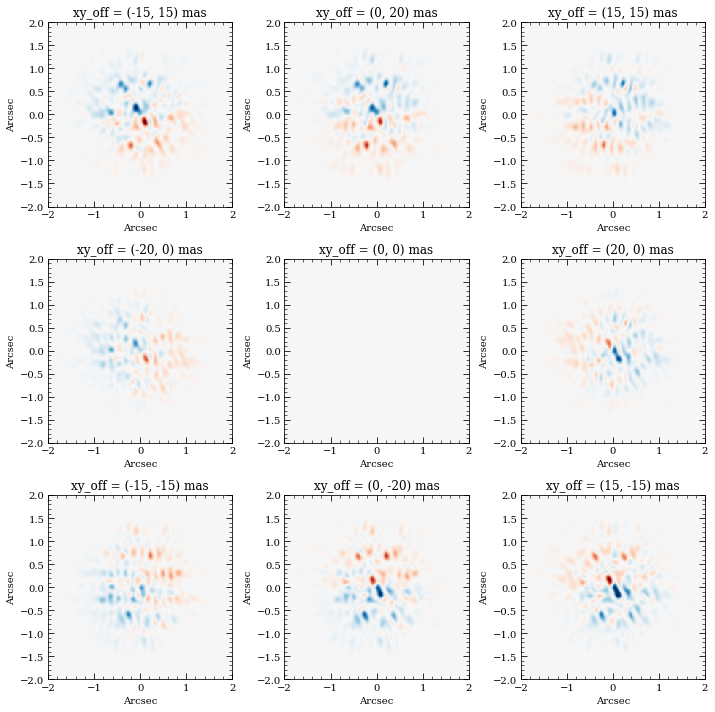

In [27]:
fig, axes = plt.subplots(3,3, figsize=(10,10))
axes = axes.flatten()


im = psf_resid[0]
vmin, vmax = np.array([-1,1]) * np.max(np.abs(im)) * 0.9
xylim = np.array([-1,1])*2
for i, ax in enumerate(axes):
    im = psf_resid[i]
    
    
    extent = np.array([-1,1,-1,1]) * pixscale_over * im.shape[0] / 2
    ax.imshow(im, vmin=vmin, vmax=vmax, extent=extent, cmap='RdBu')
    
    ax.set_title('xy_off = {} mas'.format(xy_offset[i]))
    
    ax.set_xlim(xylim)
    ax.set_ylim(xylim)
    
    ax.set_xlabel('Arcsec')
    ax.set_ylabel('Arcsec')

fig.tight_layout()

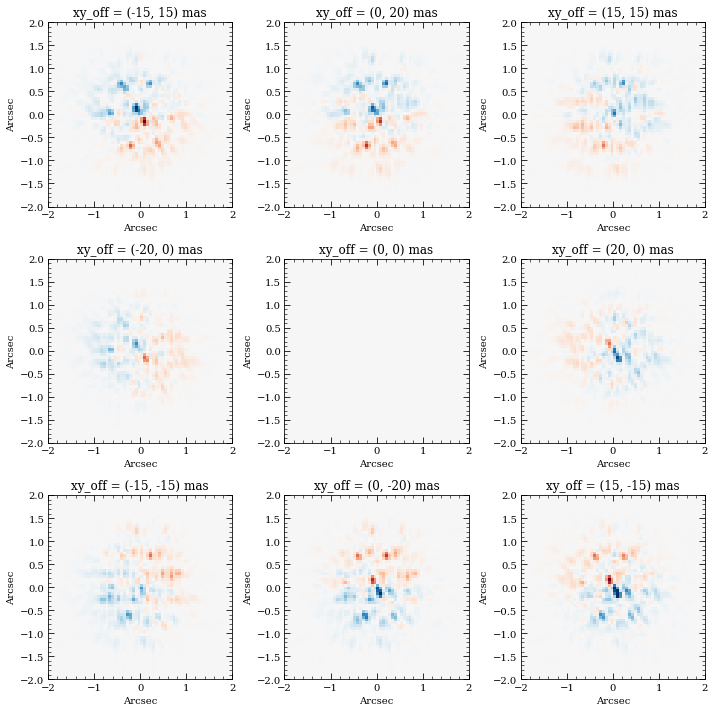

In [28]:
fig, axes = plt.subplots(3,3, figsize=(10,10))
axes = axes.flatten()


im = nrc_utils.frebin(psf_resid[0], dimensions=fov_pix)
vmin, vmax = np.array([-1,1]) * np.max(np.abs(im)) * 0.9
xylim = np.array([-1,1])*2
for i, ax in enumerate(axes):
    im = nrc_utils.frebin(psf_resid[i], dimensions=fov_pix)
    extent = np.array([-1,1,-1,1]) * pixscale * im.shape[0] / 2
    ax.imshow(im, vmin=vmin, vmax=vmax, extent=extent, cmap='RdBu')
    
    ax.set_title('xy_off = {} mas'.format(xy_offset[i]))
    
    ax.set_xlim(xylim)
    ax.set_ylim(xylim)
    
    ax.set_xlabel('Arcsec')
    ax.set_ylabel('Arcsec')

fig.tight_layout()

In [17]:
psf_sum = np.array([psf.sum() for psf in psf_arr])
psf_max = np.array([psf.max() for psf in psf_arr])
for psf in psf_arr:
    print(psf.max(), psf.sum())

7.04058404987797e-06 0.001967603026469025
7.297607808031373e-06 0.001961071218375933
7.5450162884250026e-06 0.0019557897706808393
7.107390680762913e-06 0.0019670158393672588
7.177567160167211e-06 0.0019531969130472445
7.688729622206375e-06 0.001952385116473933
6.881925491147903e-06 0.0019638088850442255
7.42909990520065e-06 0.001957068839882334
7.429321020144705e-06 0.0019535339781857697


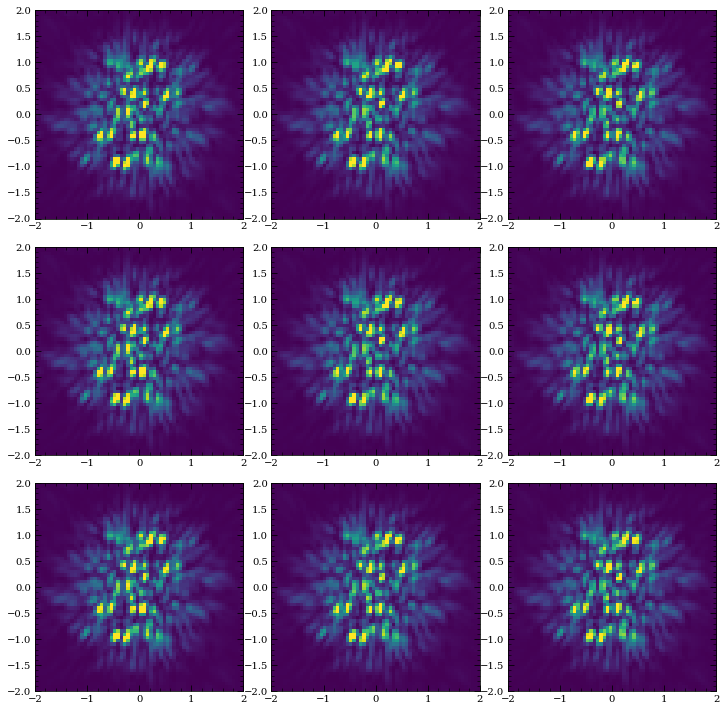

In [50]:
fig, axes = plt.subplots(3,3, figsize=(10,10))
axes = axes.flatten()

sig = np.std(psf_arr[0])
for i, ax in enumerate(axes):
    im = psf_arr[i]
    extent = np.array([-1,1,-1,1]) * nrc.pixelscale * im.shape[0] / 2
    ax.imshow(im, vmin=0, vmax=10*sig, extent=extent)
    
    ax.set_xlim(-2,2)
    ax.set_ylim(-2,2)

fig.tight_layout()

In [71]:
psf_mean = np.mean(psf_arr, axis=0)
psf_resid = psf_arr - psf_arr[4]

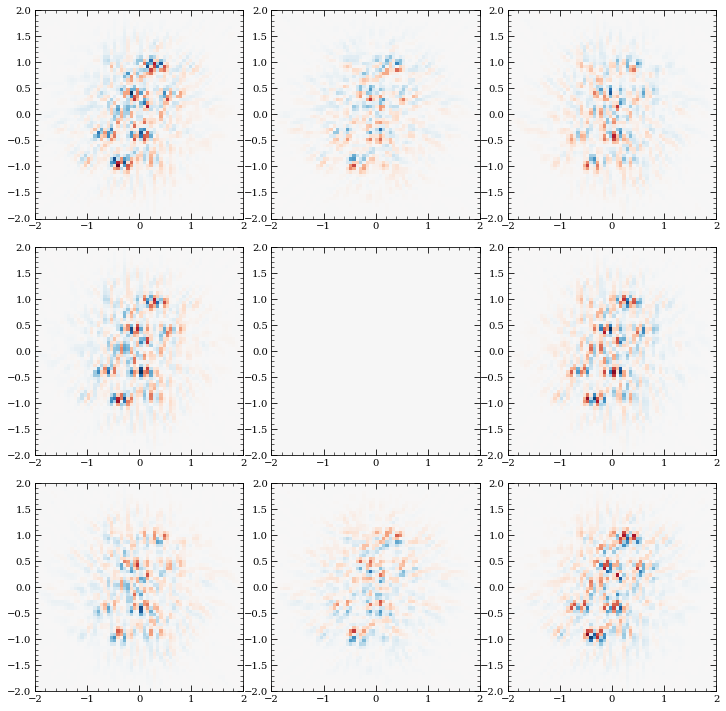

In [72]:
fig, axes = plt.subplots(3,3, figsize=(10,10))
axes = axes.flatten()

vmin, vmax = np.array([-1,1]) * np.max(np.abs(psf_resid)) * 0.9
for i, ax in enumerate(axes):
    im = psf_resid[i]
    extent = np.array([-1,1,-1,1]) * nrc.pixelscale * im.shape[0] / 2
    ax.imshow(im, vmin=vmin, vmax=vmax, extent=extent, cmap='RdBu')
    
    ax.set_xlim(-2,2)
    ax.set_ylim(-2,2)

fig.tight_layout()

In [8]:
nrc0 = nrc_hci(pupil='CIRCLYOT', mask='MASK335R', filter='F335M', ngroup=10,
               quick=True, force=True, save=False, fov_pix=128)

In [43]:
psf0_arr = np.array([nrc0.gen_offset_psf(r/1000, th) for r,th in rt_offset])

In [44]:
psf0_mean = np.mean(psf0_arr, axis=0)
psf0_resid = psf0_arr - psf0_mean

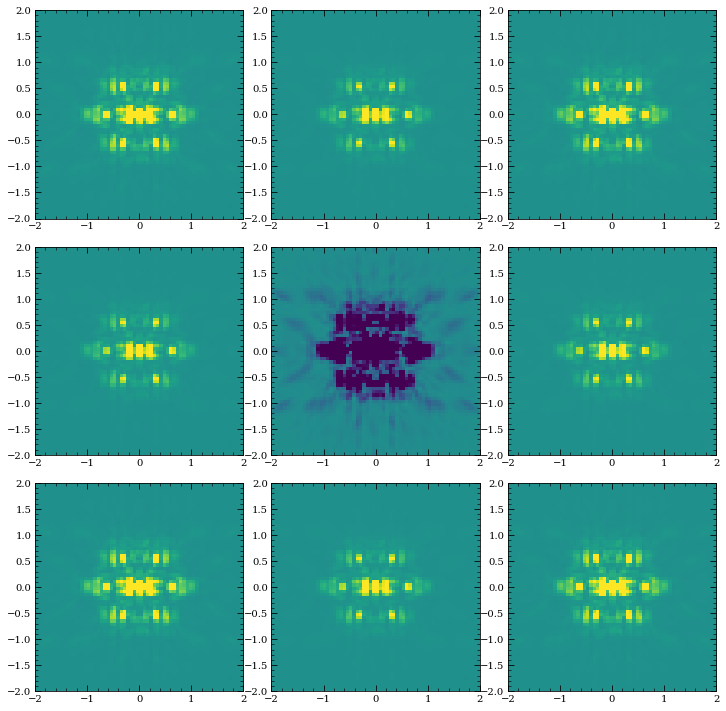

In [46]:
fig, axes = plt.subplots(3,3, figsize=(10,10))
axes = axes.flatten()

sig = np.std(psf0_resid[0])
for i, ax in enumerate(axes):
    im = psf0_resid[i]
    extent = np.array([-1,1,-1,1]) * nrc.pixelscale * im.shape[0] / 2
    ax.imshow(im, vmin=-5*sig, vmax=5*sig, extent=extent)
    
    ax.set_xlim(-2,2)
    ax.set_ylim(-2,2)

fig.tight_layout()

In [9]:
for r, th in rt_offset:
    psf = nrc0.gen_offset_psf(r/1000, th)
    print(psf.max(), psf.sum())

7.177573340974739e-06 0.001954064568410739
7.177572987488432e-06 0.0019540149463689238
7.177573340974739e-06 0.001954064568410739
7.177572987488432e-06 0.0019540149463689238
7.177567160167211e-06 0.0019531969130472445
7.177572987488432e-06 0.0019540149463689238
7.177573340974739e-06 0.001954064568410739
7.177572987488432e-06 0.0019540149463689238
7.177573340974739e-06 0.001954064568410739


In [46]:
psf0.sum()

0.001961071218375933

In [42]:
psf = nrc.gen_offset_psf(0.1,0)
print(psf.sum())

0.0020934938050585893


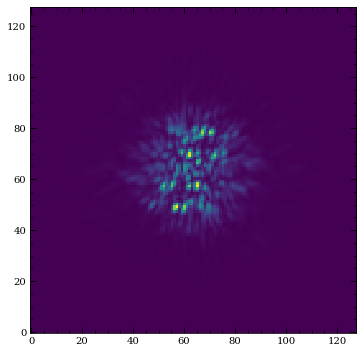

In [35]:
plt.imshow(psf)